# Eletiva NLP - Avaliação Intermediária
## Detecção de Fake News com NLP
### Aluno: Raphael Lahiry
---
### Introdução
A disseminação de notícias falsas tem se tornado uma preocupação crescente na era digital, especialmente com o aumento do uso das redes sociais como fonte de informação. Este projeto tem como objetivo desenvolver um pipeline de classificação de notícias, que identifica e diferencia notícias verdadeiras de falsas, a partir do dataset **WELFake**, disponível no [Kaggle](https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification).

---
## Entendendo o dataset

In [147]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [148]:
df = pd.read_csv("WELFake_Dataset.csv", index_col=0)
df.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72134 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   text    72095 non-null  object
 2   label   72134 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


Como o dataset é muito grande, vamos utilizar apenas um subconjunto representativo dos dados, para poder realizar o treinamento de forma mais eficiente.

In [150]:
df, _ = train_test_split(df, test_size=0.9, stratify=df['label'], random_state=42)

In [151]:
df['label'].value_counts()

label
1    3710
0    3503
Name: count, dtype: int64

Vamos limpar as linhas que possuem dados vazios na coluna 'text'

In [152]:
df.dropna(subset=['text'], inplace=True)

In [153]:
df.isnull().sum()

title    64
text      0
label     0
dtype: int64

A coluna 'title' ainda possui dados faltantes, porém como essa coluna não será utilizada durante o processo de classificação, podemos ignorá-la.

---

## Análise Exploratória

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt

Para entender melhor nossa variável target, que é a coluna 'label', vamos renomear os valores binários de '0' para 'fake' e '1' para 'real'.

In [155]:
df["label"] = df["label"].replace({0: "fake", 1: "real"})

In [156]:
df['label'].value_counts()

label
real    3703
fake    3503
Name: count, dtype: int64

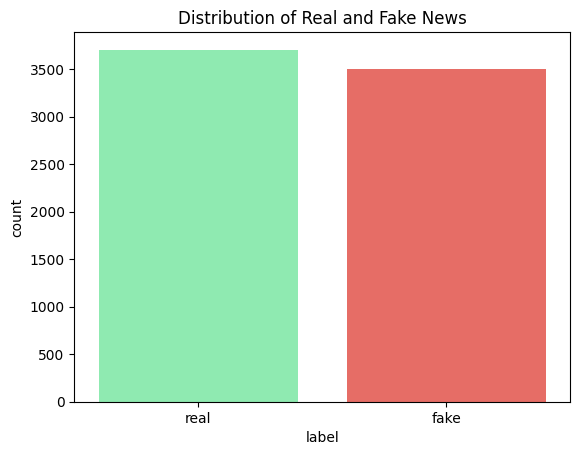

In [157]:
sns.countplot(x='label', data=df, hue='label', palette={'fake': "xkcd:coral", 'real': "xkcd:seafoam"})
plt.title('Distribution of Real and Fake News')
plt.show()

Pela quantidade de dados em cada uma das duas classes, podemos observar que o dataset está balanceado.

---

## Pré-processamento

In [158]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rapha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rapha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rapha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rapha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [159]:
# começamos limpando o texto, removendo os números e os caracteres não alfabéticos, já que não agregam valor semantico
def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text.lower())
    return ' '.join(text.split())

# após limpar o texto e formar os tokens, vamos remover os tokens que são stopwords
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

# com os tokens formados, vamos aplicar a função lemmatize para formar tokens lemmatizados, que mantem o significado semântico
def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokens]

In [160]:
# limpeza
df['clean_text'] = df['text'].apply(clean_text)

# tokenização
df['tokens'] = df['clean_text'].apply(nltk.word_tokenize)

# remoção de stop words
df['clean_tokens'] = df['tokens'].apply(remove_stopwords)

# lematização
df['lemmatized_tokens'] = df['clean_tokens'].apply(lemmatize)

# junção dos tokens para a formação de sentenças completas
df['processed_text'] = df['lemmatized_tokens'].apply(lambda tokens: ' '.join(tokens))


---

## Feature Engineering

In [161]:
from sklearn.feature_extraction.text import TfidfVectorizer

Utilizamos o vetorizador TF-IDF para transformar o texto pré-processado em uma representação numérica para ser utilizada como entrada para o modelo de classificação.

In [162]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['processed_text']).toarray()

Precisamos converter os valores da coluna 'label' de volta para formato binário, para podermos fazer o treinamento

In [163]:
df["label"] = df["label"].replace({"fake": 0, "real": 1})
y = df['label']

C:\Users\rapha\AppData\Local\Temp\ipykernel_32924\256706347.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["label"] = df["label"].replace({"fake": 0, "real": 1})


---

## Treinamento e avaliação dos modelos

In [164]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score


### Train Test Split

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Treinando os classificadores

In [166]:
# Train Support Vector Machine classifier
svm_classifier = SVC(kernel="linear", random_state=42)
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [167]:
# Train Random Forest classifier
rfc_classifier = RandomForestClassifier(random_state=42)
rfc_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [168]:
# Train Logistic Regression classifier
lr_classifier = LogisticRegression(random_state=42)
lr_classifier.fit(X_train, y_train)

LogisticRegression(random_state=42)

### Avaliando a performance dos classificadores

In [169]:
classifiers = {
    'Logistic Regression': lr_classifier,
    'Random Forest': rfc_classifier,
    'Support Vector Machine': svm_classifier
}

results = {}

for name, model in classifiers.items():
    
    y_pred = model.predict(X_test)
    
    accuracy = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results[name] = {
        'Balanced Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }


pd.DataFrame(results).T

,Balanced Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.910084,0.911342,0.910731,0.910640
Random Forest,0.900414,0.900551,0.900555,0.900548
Support Vector Machine,0.928008,0.928405,0.928307,0.928284


Vamos entender quais foram as palavras mais importantes para a classificação com o SVM, que foi o modelo que desempenhou melhor

In [170]:
import numpy as np
import pandas as pd

coefficients = svm_classifier.coef_

feature_names = vectorizer.get_feature_names_out()
coef_df = pd.DataFrame(coefficients, columns=feature_names)

top_n = 5

for i in range(coefficients.shape[0]):
    top_features_idx = np.argsort(coef_df.iloc[i])[-top_n:]
    bottom_features_idx = np.argsort(coef_df.iloc[i])[:top_n]
    top_features = coef_df.columns[top_features_idx]
    top_values = coef_df.iloc[i, top_features_idx]
    bottom_features = coef_df.columns[bottom_features_idx]
    bottom_values = coef_df.iloc[i, bottom_features_idx]

    print("Palavras mais importantes (positivas):")
    for word, value in zip(top_features, top_values):
        print(f"{word}: {value:.4f}")
    
    print("Palavras mais importantes (negativas):")
    for word, value in zip(bottom_features, bottom_values):
        print(f"{word}: {value:.4f}")
    

Palavras mais importantes (positivas):
hillary: 2.5140
featured: 2.7210
com: 2.7699
image: 2.8257
via: 6.0231
Palavras mais importantes (negativas):
reuters: -8.9301
said: -6.3415
follow: -4.1077
breitbart: -3.1475
twitter: -3.1349


---

### Avaliação do tamanho do Dataset

In [118]:
import numpy as np
from sklearn.model_selection import learning_curve

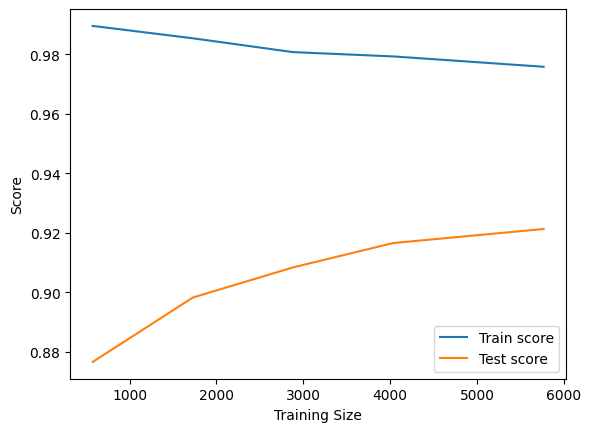

In [119]:
train_sizes, train_scores, test_scores = learning_curve(svm_classifier, X, y, cv=5, train_sizes=[0.1, 0.3, 0.5, 0.7, 1.0])

plt.plot(train_sizes, train_scores.mean(axis=1), label='Train score')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend()
plt.show()

Podemos observar que o modelo tem um desempenho melhor com mais dados de treinamento, reduzindo o overfitting, e que o aumento adicional de dados pode melhorar um pouco mais o desempenho do modelo no teste, embora a taxa de melhoria esteja diminuindo como visto no gráfico.

---

### Análise por Tópicos

In [178]:
from sklearn.metrics import accuracy_score
from sklearn.decomposition import LatentDirichletAllocation

In [172]:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_train)

LatentDirichletAllocation(n_components=5, random_state=42)

In [173]:
# Visualize topics
for i, topic in enumerate(lda.components_):
    print(f"Topic {i}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

Topic 0:
['zika', 'en', 'bundy', 'maduro', 'der', 'la', 'assange', 'rohingya', 'de', 'myanmar']
Topic 1:
['year', 'republican', 'mr', 'people', 'would', 'president', 'clinton', 'state', 'said', 'trump']
Topic 2:
['comment', 'og', 'result', 'lying', 'funny', 'http', 'com', 'via', 'maher', 'text']
Topic 3:
['broadcast', 'tune', 'est', 'room', 'taliban', 'kabul', 'join', 'pm', 'boiler', 'acr']
Topic 4:
['iraq', 'bentley', 'kurd', 'baghdad', 'zuma', 'iraqi', 'mugabe', 'rico', 'puerto', 'kurdish']


In [180]:
def evaluate_accuracy_by_topic(y_test, y_pred_test, test_topic_labels):
    accuracies = {}
    for topic in np.unique(test_topic_labels):
        topic_indices = (test_topic_labels == topic)
        
        if topic_indices.sum() > 0:
            topic_accuracy = accuracy_score(y_test[topic_indices], y_pred_test[topic_indices])
            accuracies[topic] = topic_accuracy
        else:
            accuracies[topic] = None
            
    return accuracies

topic_accuracies = evaluate_accuracy_by_topic(y_test, y_pred_test, test_topic_labels)

for topic, acc in topic_accuracies.items():
    if acc is not None:
        print(f"Acurácia para o Tópico {topic}: {acc:.4f}")
    else:
        print(f"Tópico {topic} não tem amostras no conjunto de teste.")

Acurácia para o Tópico 0: 1.0000
Acurácia para o Tópico 1: 0.9275
Acurácia para o Tópico 2: 1.0000
Acurácia para o Tópico 3: 1.0000


In [174]:
train_topic_distribution = lda.transform(X_train)
test_topic_distribution = lda.transform(X_test)

In [175]:
train_topic_labels = train_topic_distribution.argmax(axis=1)
test_topic_labels = test_topic_distribution.argmax(axis=1)

In [176]:
def two_layer_classifier(X_train, y_train, X_test, train_topic_labels, test_topic_labels):
    predictions = np.zeros(X_test.shape[0], dtype=int)

    for topic in np.unique(train_topic_labels):
        topic_indices = (train_topic_labels == topic)
        
        if topic_indices.sum() > 0:
            unique_classes = np.unique(y_train[topic_indices])
            if len(unique_classes) > 1:
                topic_clf = SVC(kernel="linear")
                topic_clf.fit(X_train[topic_indices], y_train[topic_indices])
            
                test_topic_indices = (test_topic_labels == topic)
                predictions[test_topic_indices] = topic_clf.predict(X_test[test_topic_indices])
            else:
                test_topic_indices = (test_topic_labels == topic)
                predictions[test_topic_indices] = unique_classes[0]
    
    return predictions

y_pred_test = two_layer_classifier(X_train, y_train, X_test, train_topic_labels, test_topic_labels)
balanced_acc = balanced_accuracy_score(y_test, y_pred_test)
print(f"Two-Layer Classifier Balanced Accuracy: {balanced_acc:.4f}")


Two-Layer Classifier Balanced Accuracy: 0.9285


O classificador de duas camadas melhorou a
precisão da classificação, se comparado com o SVM único utilizado anteriormente.